In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os.path import join

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [4]:
sns.set()

## Pre-processing 

Same as before

In [5]:
def data_preprocessing(path):
    features = pd.read_csv(path)
    features = features.drop(['year', 'weekofyear'],
                            axis = 1)
    features = features.drop(['reanalysis_sat_precip_amt_mm',
                              'reanalysis_tdtr_k'],
                            axis = 1)
    features = features.rename({'week_start_date': 'ds'}, axis = 1)
    features_sj = features[features['city'] == 'sj'].drop('city', axis = 1)
    features_iq = features[features['city'] == 'iq'].drop('city', axis = 1)
    return (features_sj, features_iq)

In [6]:
DATA_PATH = '../data/raw'
train_sj_o, train_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_train.csv'))
test_sj, test_iq = data_preprocessing(join(DATA_PATH,
    'dengue_features_test.csv'))

In [7]:
train_labels = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))

In [24]:
train_sj_o.head()

,ds,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,14.012857,25.442857,6.900000,29.4,20.0,16.0
1,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,15.372857,26.714286,6.371429,31.7,22.2,8.6
2,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,16.848571,26.714286,6.485714,32.2,22.8,41.4
3,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,16.672857,27.471429,6.771429,33.3,23.3,4.0
4,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,17.210000,28.942857,9.371429,35.0,23.9,5.8


## Simple model

### San Juan

In [10]:
to_drop = list(train_sj_o.columns[1:])
train_sj = train_sj_o.drop(to_drop, axis = 1)
train_sj['y'] = train_labels[train_labels['city'] == 'sj']['total_cases']

In [21]:
model_sj = Prophet(
    growth = 'linear',
    changepoint_prior_scale = 0.1,
    yearly_seasonality = 10,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

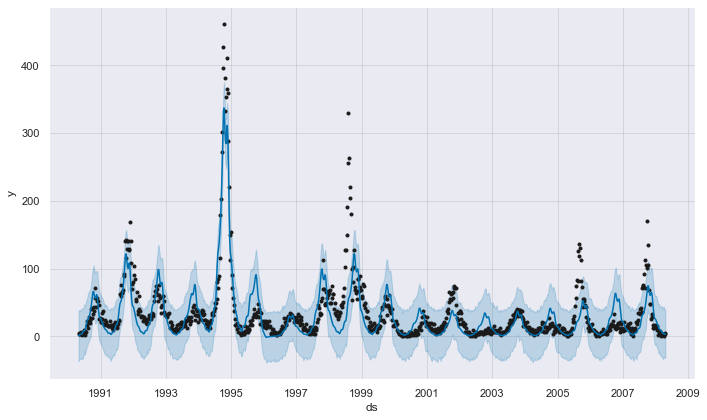

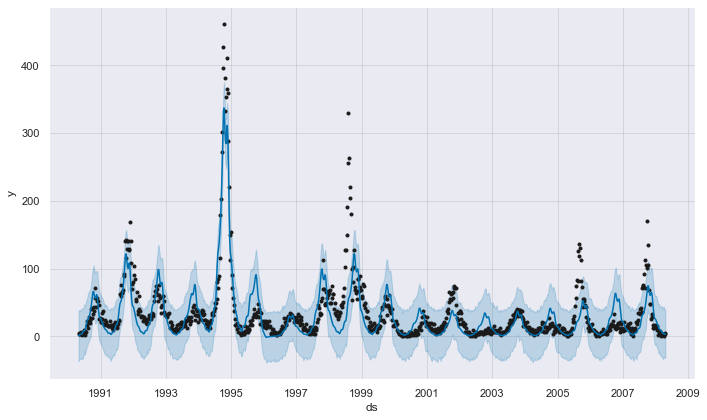

In [22]:
model_sj.fit(train_sj)
forecast_sj = model_sj.predict(train_sj)
model_sj.plot(forecast_sj)

Cross validation

In [23]:
cv_sj = cross_validation(model_sj, horizon = '730 days')
mean_absolute_error(cv_sj['yhat'], cv_sj['y'])

INFO:fbprophet:Making 10 forecasts with cutoffs between 1997-04-25 00:00:00 and 2006-04-23 00:00:00


31.392843971592047

Performs slightly better than previous iteration of prophet

### Iquitos

In [14]:
to_drop = list(train_iq.columns[1:])
train_iq = train_iq.drop(to_drop, axis = 1)
train_iq['y'] = train_labels[train_labels['city'] == 'iq']['total_cases']

In [15]:
model_iq = Prophet(
    growth = 'linear',
    yearly_seasonality = 5,
    weekly_seasonality = False,
    daily_seasonality = False,
    seasonality_mode = 'multiplicative'
)

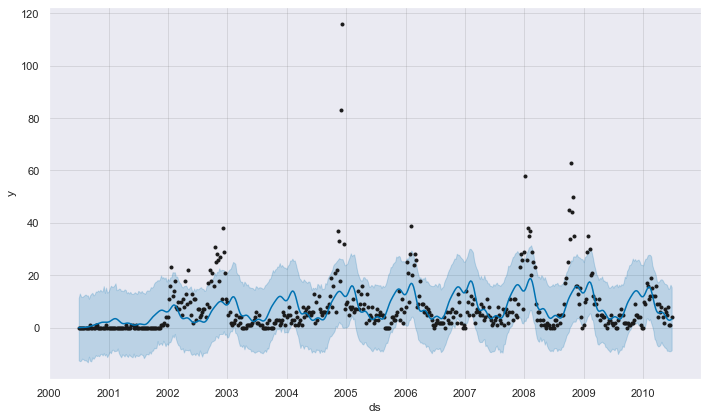

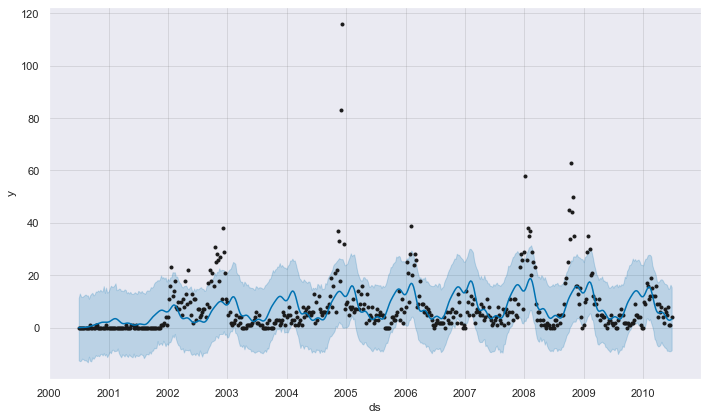

In [16]:
model_iq.fit(train_iq)
forecast_iq = model_iq.predict(train_iq)
model_iq.plot(forecast_iq)

Cross validation

In [17]:
cv_iq = cross_validation(model_iq, horizon = '730 days')
mean_absolute_error(cv_iq['yhat'], cv_iq['y'])

INFO:fbprophet:Making 2 forecasts with cutoffs between 2007-06-26 00:00:00 and 2008-06-25 00:00:00


9.852642902073114

Iquitos performs worse with multiplicative seasonality, so we remove it

NOTE: Setting `seasonality_mode` to additive significantly improved the score. We're down to 26 MAE for San Jose, and

### Making predictions for Driven Data

In [38]:
prophet_basic_sub = pd.read_csv(join(DATA_PATH, 'submission_format.csv'))

San juan

In [31]:
to_drop = list(test_sj.columns[1:])
test_sj = test_sj.drop(to_drop, axis = 1)
forecast_sj = model_sj.predict(test_sj)['yhat'].values

Iquitos

In [33]:
test_iq = test_iq.drop(to_drop, axis = 1)
forecast_iq = model_iq.predict(test_iq)['yhat'].values

In [35]:
y_pred = np.concatenate((forecast_sj, forecast_iq))

In [39]:
prophet_basic_sub['total_cases'] = np.round(y_pred).astype(int)

In [41]:
prophet_basic_sub.to_csv('../models/prophet_basic_sub.csv', index = None)

### Results

25.7 MAE on the leaderboard, a significant improvement over the previous